# NN autoencoder on Frame Spectrum data 

Taken from https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/3_NeuralNetworks/autoencoder.py


In [1]:
from __future__ import division, print_function, absolute_import
%matplotlib notebook
from numpy import *
import wget
from scipy.io import wavfile
import librosa
import tensorflow as tf
import numpy as np
import os
from utils import *
from matplotlib.pylab import *
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from ipywidgets import interact, interactive, fixed

plt.style.use('ggplot')


In [71]:
from utils import Data

N = 5000

L = 512
f1_ = 20.
f2_ = 80.
df1 = 25.
df2 = 25.
sf1 = 20.
sf2 = 20.

x = ones((N,L))*linspace(0,100,L)

r = (ones((L,N))*rand(N)).T
a1 = 1+(ones((L,N))*randn(N)).T*0.1
a2 = 1+(ones((L,N))*randn(N)).T*0.1

f1 = f1_ + r*df1
f2 = f2_ - r*df2

S = a1*exp(-1./sf1*(x-f1)**2) + a2*exp(-1./sf2*(x-f2)**2)

data = Data( S )
n_spectrums = data.length
print(S.shape)

# plot(S[0])
# plot(x[0]-f1[0])


(5000, 512)


In [72]:
print(data.data.shape)
data.next_batch(10).shape


(5000, 512)


(10, 512)

In [73]:
# Parameters
learning_rate = 0.001
training_epochs = 100
batch_size = 2**10

display_step = 5
l2scale = 0.1
# Network Parameters




In [74]:
tf.reset_default_graph()

dimensions= [256,128,64,32,16,8,4,2]
# dimensions= [256,128,64]
dimensions= [256,128,64,32]
dimensions= [256,128,64,32,16,8,4]
dimensions= [256,128,64,32,16,8]


# tf Graph input (only pictures)
n_input = S.shape[1]

X = tf.placeholder("float", [None, n_input])

# let's first copy our X placeholder to the name current_input
current_input = X

# We're going to keep every matrix we create so let's create a list to hold them all
Ws = []
bs = []
activs =[]

# We'll create a for loop to create each layer:
for layer_i, n_output in enumerate(dimensions):

    # just like in the last session,
    # we'll use a variable scope to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("encoder/layer/{}".format(layer_i)):

        # Create a weight matrix which will increasingly reduce
        # down the amount of information in the input by performing
        # a matrix multiplication
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05),
            regularizer = tf.contrib.layers.l2_regularizer(l2scale))

        # Now we'll multiply our input by our newly created W matrix
        # and add the bias
        h = tf.matmul(current_input, W)
        b = tf.get_variable(name='b',shape=[n_output],initializer=tf.random_normal_initializer(mean=0.0, stddev=0.05),
            regularizer = tf.contrib.layers.l2_regularizer(l2scale))

        # And then use a relu activation function on its output
        current_input = tf.nn.relu(tf.add(h,b))

        bs.append(b)
        # Finally we'll store the weight matrix so we can build the decoder.
        Ws.append(W)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        print([n_input, n_output])

        n_input = n_output
        activs.append(current_input)
        
# We'll first reverse the order of our weight matrices
Ws = Ws[::-1]
bs = bs[::-1]

encoder_op = current_input

# then reverse the order of our dimensions
# appending the last layers number of inputs.
dimensions = dimensions[::-1][1:] + [S.shape[1]]

print(dimensions)

for layer_i, n_output in enumerate(dimensions):
    # we'll use a variable scope again to help encapsulate our variables
    # This will simply prefix all the variables made in this scope
    # with the name we give it.
    with tf.variable_scope("decoder/layer/{}".format(layer_i)):

        # Now we'll grab the weight matrix we created before and transpose it
        # So a 3072 x 784 matrix would become 784 x 3072
        # or a 256 x 64 matrix, would become 64 x 256
        W = tf.transpose(Ws[layer_i])

        b = bs[layer_i]

        # Now we'll multiply our input by our transposed W matrix
        h = tf.matmul(tf.add(current_input,b), W)
        # And then use a relu activation function on its output
        current_input = tf.nn.relu(h)

        # We'll also replace n_input with the current n_output, so that on the
        # next iteration, our new number inputs will be correct.
        print([n_input, n_output])

        n_input = n_output
        activs.append(current_input)


Y = current_input

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
reg_constant = 0.00  # Choose an appropriate one.
reg = reg_constant * tf.reduce_mean(reg_losses)
cost = tf.reduce_mean(tf.squared_difference(X, Y)) + reg

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)



[512, 256]
[256, 128]
[128, 64]
[64, 32]
[32, 16]
[16, 8]
[16, 32, 64, 128, 256, 512]
[8, 16]
[16, 32]
[32, 64]
[64, 128]
[128, 256]
[256, 512]


Epoch: 0001 cost= 0.102376744 reg= 0.000000000


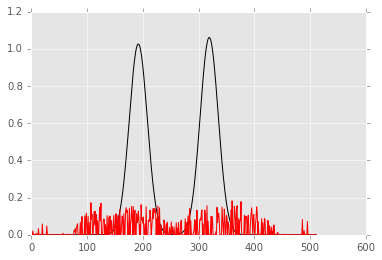

0.182536
Epoch: 0006 cost= 0.086799845 reg= 0.000000000
Epoch: 0011 cost= 0.086889990 reg= 0.000000000
Epoch: 0016 cost= 0.086694807 reg= 0.000000000
Epoch: 0021 cost= 0.086243086 reg= 0.000000000


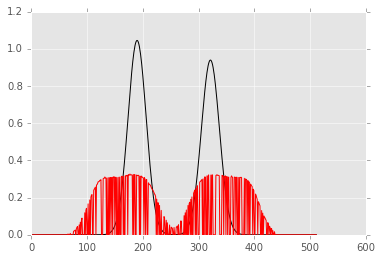

0.326652
Epoch: 0026 cost= 0.086013816 reg= 0.000000000
Epoch: 0031 cost= 0.086400867 reg= 0.000000000
Epoch: 0036 cost= 0.086684465 reg= 0.000000000
Epoch: 0041 cost= 0.086641736 reg= 0.000000000


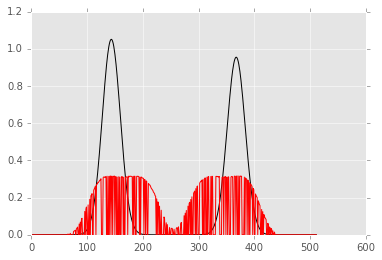

0.316487
Epoch: 0046 cost= 0.086184867 reg= 0.000000000
Epoch: 0051 cost= 0.086997688 reg= 0.000000000
Epoch: 0056 cost= 0.086491086 reg= 0.000000000
Epoch: 0061 cost= 0.085808471 reg= 0.000000000


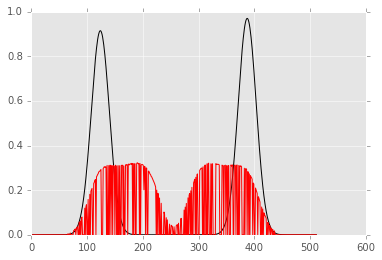

0.322698
Epoch: 0066 cost= 0.085987806 reg= 0.000000000
Epoch: 0071 cost= 0.085349828 reg= 0.000000000
Epoch: 0076 cost= 0.050891064 reg= 0.000000000
Epoch: 0081 cost= 0.027493445 reg= 0.000000000


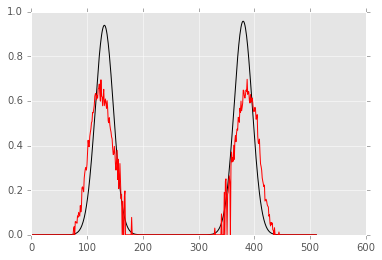

0.696692
Epoch: 0086 cost= 0.013885039 reg= 0.000000000
Epoch: 0091 cost= 0.006730301 reg= 0.000000000
Epoch: 0096 cost= 0.004780270 reg= 0.000000000
Optimization Finished!


In [75]:
%matplotlib inline


# Initializing the variables
init = tf.initialize_all_variables()

# Launch the graph
config = tf.ConfigProto( device_count = {'GPU': 0} )
sess = tf.Session(config=config)
sess.run(init)
total_batch = int(data.length/batch_size)
# Training cycle
figure()
costs = []
regs = []
for epoch in range(training_epochs):
    # Loop over all batches
    for i in range(total_batch):
        batch_xs = data.next_batch(batch_size)
        # Run optimization op (backprop) and cost op (to get loss value)
        opt, cost_value, reg_value = sess.run([optimizer, cost, reg], feed_dict={X: batch_xs})
        costs.append(cost_value)
        regs.append(reg_value)
        
    # Display logs per epoch step
    if epoch % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1),"cost=", "{:.9f}".format(cost_value),"reg=","{:.9f}".format(reg_value))
        
    if epoch % 20 == 0:
        out = sess.run([Y], feed_dict={X: [batch_xs[0]]})
        plot(batch_xs[0],'k')
        plot(out[0].T,'r')
        show()
        print(out[0].max())


print("Optimization Finished!")

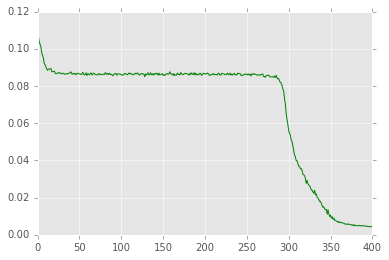

In [76]:
%matplotlibtlibplotlib notebook
figure()
plot(costs,'g')
plot(regs,'b')

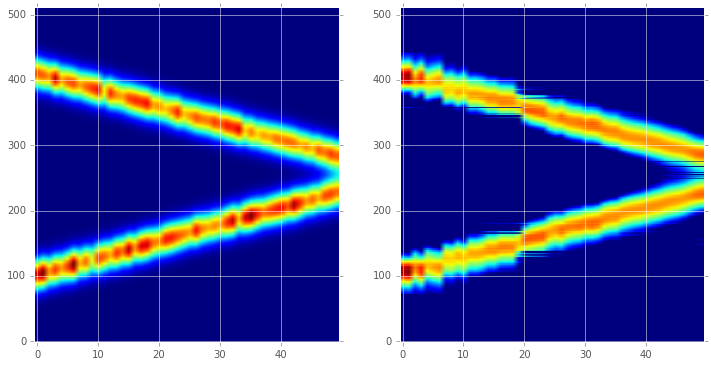

In [80]:
original = data.data[ixf1]
range_ = range(0,n_spectrums,100)
original = original[range_]

out = sess.run(Y, feed_dict={X: original})

ixf1 = np.argsort(f1[:,0])


figure(figsize=(12,6))
subplot(1,2,1)
imshow((original).T,aspect='auto',origin='bottom')
# ylim(0,100)

subplot(1,2,2)
imshow((out).T,aspect='auto',origin='bottom')
# ylim(0,100)


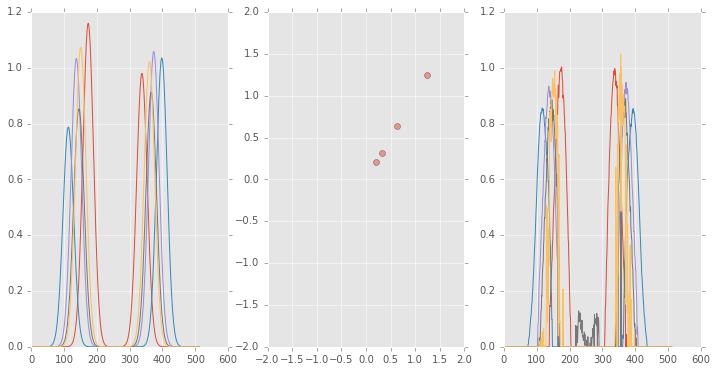

In [82]:
inputs = [data.data[20:25]]

figure(figsize=(12,6))
for i,input_ in enumerate(inputs):
#     figure(figsize=(12,6))
    subplot(1,3,1)
    plot( (input_).T )  
    middle,out = sess.run([encoder_op,Y], feed_dict={X: input_})
    subplot(1,3,2)
    plot(middle[:,0],middle[:,0],'o',alpha=0.5)

    xlim(-2,2)
    ylim(-2,2)
    subplot(1,3,3)
    plot( (out).T )


/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_base.py:2787: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))
/usr/local/lib/python3.4/dist-packages/matplotlib/axes/_base.py:3045: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0.0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))


(1000, 8)

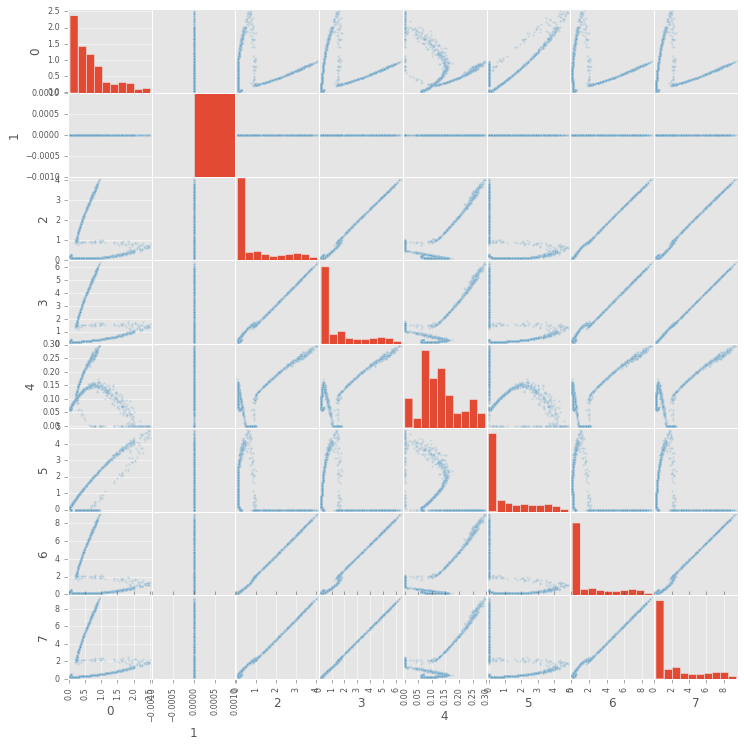

In [87]:
ds = data.data[0:1000]
middle,out = sess.run([encoder_op,Y], feed_dict={X: ds})
import pandas as pd
from pandas.tools.plotting import scatter_matrix
scatter_matrix(pd.DataFrame(middle), alpha=0.2, figsize=(12, 12))
(middle).shape

# figure(figsize=(12,8))
# imshow(middle.T,aspect='auto',interpolation='none')

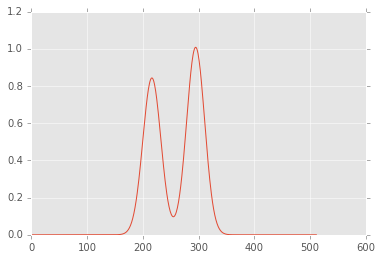

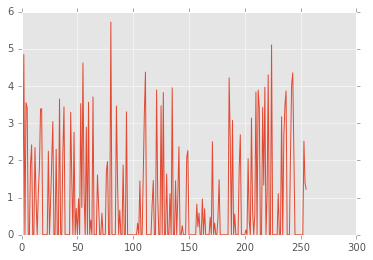

In [84]:
orig = [data.data[0]]
out = sess.run([activs[0]], feed_dict={X: orig})
figure()
plot(orig[0])
figure()
plot(out[0].T)
